# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [1]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [8]:
from sklearn.base import BaseEstimator, ClusterMixin

from collections import namedtuple
from operator import attrgetter, itemgetter

from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance as scipy_distance
import heapq


def distance(a, b):
    a, b = (p.features if type(p) is Point else p for p in (a, b))
    return scipy_distance.euclidean(a, b)


class Point:
    def __init__(self, idx, features):
        self.features = features
        
        self.idx = idx
        self.cluster_id = None
        self.processed = False
        self.core_distance = np.inf
        self.reachability_distance = np.inf
        
    def __repr__(self):
        fields = [
            'idx', 'features', 'processed', 'core_distance', 'reachability_distance',
        ]
        return '<Point: {}>'.format(' '.join(map(str, attrgetter(*fields)(self))))
    
    def distance(self, other):
        return distance(self.features, other.features)
    
    
def _neighbors(points, center, epsilon):
    # naive nearest neighbors
    by_distance = zip(map(center.distance, points), points)
    by_distance = filter(lambda t: t[0] < epsilon and t[1] is not center, by_distance)
    by_distance = sorted(by_distance, key=itemgetter(0))
    return list(map(itemgetter(1), by_distance))


def core_distance(center, neighbors, epsilon, min_pts):
    if not neighbors or min_pts is not None and len(neighbors) < min_pts:
        return np.inf

    return center.distance(neighbors[:min_pts][-1])


class Points:
    def __init__(self, x, min_pts=5):
        self.min_pts = x.shape[0] - 1
        self._points = [Point(i, x_i) for i, x_i in enumerate(x)]
        self.nbrs = NearestNeighbors(n_neighbors=x.shape[0], algorithm='ball_tree').fit(x)
                     
    def __iter__(self):
        return iter(self._points)
    
    def neighbors(self, center, epsilon):
        ret = []
        distances, indices = self.nbrs.kneighbors([center.features])
        for distance, index in zip(distances[0, 1:], indices[0, 1:]):
            if distance <= epsilon:
                ret.append(self._points[index])
        return ret

    
class Seeds:
    class Seed():
        def __init__(self, distance, point):
            self.distance = distance
            self.point = point

        def __lt__(self, other):
            return (self.distance < other.distance)

        def __eq__(self, other):
            return (self.point.dx == other.point.idx)
    
    def __init__(self):
        self._seeds = []
    
    def __iter__(self):  # 
        return iter([seed.point for seed in self._seeds])

    def __next__(self):
        ret = heapq.heappop(self._seeds).point
        return ret

    def __bool__(self):
        return len(self._seeds) > 0

    def insert(self, point, distance):
        heapq.heappush(self._seeds, self.Seed(distance, point))
    
    def move(self, point, distance):
        self._seeds = list(filter(lambda seed: seed.point.idx != point.idx, self._seeds))
        heapq.heappush(self._seeds, self.Seed(distance, point))

        
def save(safe, point):
    safe.append(point)

    
def update(neighbors, center, seeds, epsilon, min_pts):
    center_core_distance = core_distance(center, neighbors, epsilon, min_pts)
    
    for point in neighbors:
        if not point.processed:
            changed = False
            new_reachability_distance = max(center_core_distance, center.distance(point))
    
            if point.reachability_distance == np.inf:
                changed = True
                point.reachability_distance = new_reachability_distance
                seeds.insert(point, new_reachability_distance)
            elif point.reachability_distance > new_reachability_distance:
                changed = True
                point.reachability_distance = new_reachability_distance
                seeds.move(point, new_reachability_distance)


def OPTICS(x, epsilon, min_pts):
    points = Points(x, min_pts)
    ret = []      
    for center in points:
        if center.processed:
            continue
            
        N = points.neighbors(center, epsilon)[:min_pts]
        center.processed = True
        center.core_distance = core_distance(center, N, epsilon, min_pts)
        save(ret, center)
        
        if center.core_distance != np.inf:
            seeds = Seeds()
            update(N, center, seeds, epsilon if epsilon != np.inf else center.core_distance, min_pts)
            while seeds:
                point = next(seeds)
                N = points.neighbors(point, epsilon)
                point.processed = True
                save(ret, point)
                
                if core_distance(point, N, epsilon, min_pts) != np.inf:
                    update(N, point, seeds, epsilon, min_pts)
    return ret
                    
    
def cluster_ids(points, epsilon, min_pts):
    cluster_id = 0
    ret = []
    for point in points:
        if point.reachability_distance > epsilon:
            if point.core_distance <= epsilon:
                cluster_id += 1
                ret.append(cluster_id)
            else:
                ret.append(0)
        else:
            ret.append(cluster_id)
    return ret


def extract_clusters(points, epsilon, min_pts, ksi=None, verbose=0):
    clusters = []
    min_pts = min_pts or 0
    ksi = ksi or 0.1
    n = len(points)
    
    def r(idx):
        if idx > n - 1:
            import traceback
            traceback.print_stack()
        return points[idx].reachability_distance

    def is_down_point(idx):
        return idx < n - 1 and r(idx) * (1-ksi) >= r(idx+1)

    def is_up_point(idx):
        return idx >= n - 1 or r(idx) <= r(idx+1) * (1-ksi)

    d_s = []
    
    idx = 0
    d_mib = 0
    while idx < n:
        if is_down_point(idx):
            points[idx].is_down = True
            s = idx
            i = s
            while is_down_point(i) and i + 1 < n and r(idx) >= r(i + 1): 
                i += 1
                
            e = i 
            d = (s, e)

            d_s.append(d)
            
            idx = e + 1
            if idx > n - 1:
                break

        elif is_up_point(idx) or idx + 1 == n:
            points[idx].is_up = True
            s = idx
            i = s
            while is_up_point(i) and i + 1 < n and r(idx) <= r(i + 1): i += 1
            i -= 1
            e = i
            u = (s, e)
            idx = e + 1
            if idx > n - 1:
                break            
            mib = r(idx)
            for i, d in enumerate(d_s):
                if (
                        u[1] - d[0] + 1 > min_pts
                    ):
                    clusters.append((d[0], u[0]-1))
                    d_s = []
                    break
            idx += 1
            
        else:
            idx += 1
    
    ret = []
    for i in range(len(points)):
        cluster_id = 0
        for j, cluster in enumerate(clusters):
            if cluster[0] <= i <= cluster[1]:
                cluster_id = j + 1
                break
                
        ret.append(cluster_id)

    return ret
    
    
class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, epsilon=1.0, min_pts=None, max_eps=np.inf, ksi=0.20, **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        
        self.epsilon = epsilon
        self.min_pts = min_pts
        self.max_eps = max_eps
        self.ksi = ksi
        
        return
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.x_len = len(x)
        return self
    
    def predict(self, x, verbose=0):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        
        points = OPTICS(x, self.max_eps, self.min_pts)
        cluster_ids = extract_clusters(points, self.epsilon, self.min_pts, self.ksi, verbose=verbose)
        indices = {point.idx: i for i, point in enumerate(points)}
        y = [cluster_ids[indices[i]] for i in range(len(cluster_ids))]

        return y
    
    def fit_predict(self, x, y=None, verbose=0, **kwargs):
        self.fit(x, y)
        return self.predict(x, verbose=verbose, **kwargs)


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

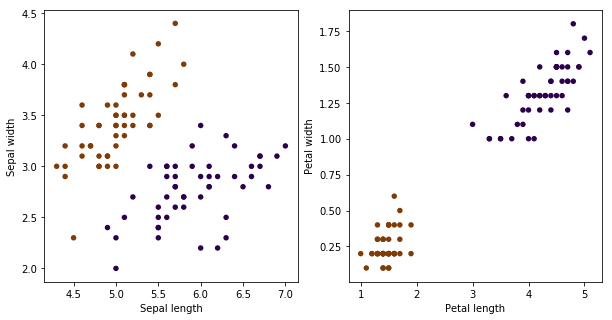

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [4]:
pred_iris = Clustering(min_pts=30).fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 0.73


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

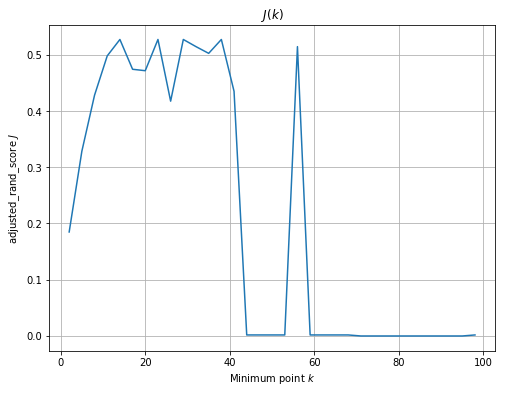

In [5]:
iris = ds.load_iris()
x = iris.data[:100]
y = iris.target[:100]
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

ks = np.arange(2, x.shape[0], 3)
criteria = np.zeros(len(ks))

def quality(x, y):
    return smt.adjusted_rand_score(y_train, y)

for i, k in enumerate(ks):
    cls = Clustering(min_pts=k)
    y_pred = cls.fit_predict(x_train)
    criteria[i] = quality(x_train, y_pred)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("adjusted_rand_score $J$")
pl.xlabel("Minimum point $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

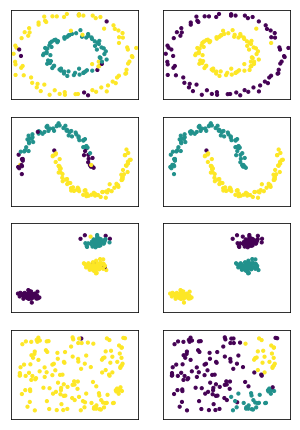

In [6]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import OPTICS as SKLearnClustering


np.random.seed(0)

n_samples = 150
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

amateur = Clustering(min_pts=15)
professional = SKLearnClustering(min_samples=15)
clses = [amateur, professional]

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    X = StandardScaler().fit_transform(X)

    for j_cls, cls in enumerate(clses):
        y_pred = cls.fit_predict(X)
        
        # plot
        plt.subplot(5, 2, 2 * i_dataset + j_cls + 1)
        plt.scatter(X[:, 0], X[:, 1], s=10, c=y_pred)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())

plt.show()

In [7]:
k = 5
cls = Clustering()
y = cls.fit_predict(x)

## Дополнительное задание (не является обязательным)


Примените три любых алгоритма кластеризации из библиотеки sklearn на выбранном вами датасете (реальные данные, датасет с kaggle и пр.). Желательно выбрать легко интерпретируемые данные - например, данные о товарах или пользователях, где есть название, пол, возраст, а так же любые другие легко воспринимаемые признаки.

После применения алгоритма покажите в каждом кластере несколько представителей и проинтерпретируйте результат.